#Import Librires form pytorch

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import PIL as image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, DataLoader
import os
import random
import shutil
from pathlib import Path
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import densenet121, DenseNet121_Weights, DenseNet
from collections import Counter
from torch import device
import torch
import os
import torch
#device = torch.device('cpu')  # Set the device to CPU





#Load data and perform data augmentation

In [24]:

Train_Data_set = Path(r"C:\Desktop\CDCS6A\CSP650\Testing and development\Split\train") # Train data set
Test_Data_set = Path(r"C:\Desktop\CDCS6A\CSP650\Testing and development\Split\test")   # val Data Set



def calculate_data(dataset_path):
    class_count  = Counter()
    class_names = []

    for class_folder in dataset_path.iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name
            class_names.append(class_folder)

            #count the number of images inthe directory
            num_images = len(list(class_folder.glob("*.*")))
            class_count[class_name] = num_images

    total_images = sum(class_count.values())
    return total_images, class_names, class_count

#total images count 
train_size, train_class, train_count = calculate_data(Train_Data_set)
test_size, test_class, test_count = calculate_data(Test_Data_set)

#print the number of Data

# Print dataset statistics
print("Data split completed!")
print(f"Train dataset size: {train_size}")
print(f"Test dataset size: {test_size}")
print("Class names:",train_class)

print("\nTraining Data:")
for cls, count in train_count.items():
    print(f"  {cls}: {count} images")

print("\nTesting Data:")
for cls, count in test_count.items():
    print(f"  {cls}: {count} images")



Data split completed!
Train dataset size: 228
Test dataset size: 100
Class names: [WindowsPath('C:/Desktop/CDCS6A/CSP650/Testing and development/Split/train/Cultivated Rice'), WindowsPath('C:/Desktop/CDCS6A/CSP650/Testing and development/Split/train/Weedy Rice')]

Training Data:
  Cultivated Rice: 114 images
  Weedy Rice: 114 images

Testing Data:
  Cultivated Rice: 50 images
  Weedy Rice: 50 images


#Data Preprocessing for training data set

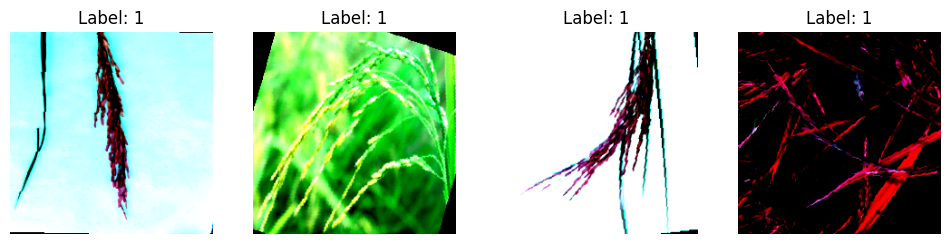

Size of Test dataset:  456


In [25]:



# Define the path to the training data
train_directory = Train_Data_set
# Define data augmentation transformations for training 
augment_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Define non-augmented transformations (basic preprocessing only)
non_augment_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Create datasets for augmented and non-augmented images
augmented_train_dataset = datasets.ImageFolder(train_directory, transform=augment_transforms)
non_augmented_train_dataset = datasets.ImageFolder(train_directory, transform=non_augment_transforms)

# Combine the datasets
from torch.utils.data import ConcatDataset
combined_Train_dataset = ConcatDataset([augmented_train_dataset, non_augmented_train_dataset])

# Create a DataLoader for the combined dataset
train_loader = DataLoader( combined_Train_dataset, batch_size=32, shuffle=True)

# Visualize a few images (both augmented and non-augmented)
def show_Augmneted_images(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()
        image = image.clip(0, 1)

        ax.imshow(image)
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.show()

# Show images from the combined datase
show_Augmneted_images(train_loader)

# Display size of the test dataset
print(f"Size of Test dataset:  {len(combined_Train_dataset)}")



#Data processing for Validation data set

In [26]:
# Define the path to the training data
test_directory = Test_Data_set

# Define data augmentation transformations for training 
augment_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Define non-augmented transformations (basic preprocessing only)
non_augment_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

augmented_test_dataset = datasets.ImageFolder(test_directory, transform=augment_transforms)
normalize_test_dataset = datasets.ImageFolder(test_directory, transform=non_augment_transforms)

combine_Test_dataset = ConcatDataset([augmented_test_dataset, normalize_test_dataset])

test_loader = DataLoader(combine_Test_dataset,batch_size=32, shuffle=False)

print(f"size of data set: {len(combine_Test_dataset)}")






size of data set: 200


#Define model for training and validation

In [27]:
model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#Finetune fully connected layer

In [28]:
num_classes = 2
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Modify the classifier to include a dropout layer before the final layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout with a probability of 0.5
    nn.Linear(model.classifier.in_features, num_classes)
)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#Ensure model is unforzen

In [29]:
# eunsre that the model is unfrezzed
for param in model.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"Layer: {name} | Frozen: {not param.requires_grad}")


Layer: features.conv0.weight | Frozen: False
Layer: features.norm0.weight | Frozen: False
Layer: features.norm0.bias | Frozen: False
Layer: features.denseblock1.denselayer1.norm1.weight | Frozen: False
Layer: features.denseblock1.denselayer1.norm1.bias | Frozen: False
Layer: features.denseblock1.denselayer1.conv1.weight | Frozen: False
Layer: features.denseblock1.denselayer1.norm2.weight | Frozen: False
Layer: features.denseblock1.denselayer1.norm2.bias | Frozen: False
Layer: features.denseblock1.denselayer1.conv2.weight | Frozen: False
Layer: features.denseblock1.denselayer2.norm1.weight | Frozen: False
Layer: features.denseblock1.denselayer2.norm1.bias | Frozen: False
Layer: features.denseblock1.denselayer2.conv1.weight | Frozen: False
Layer: features.denseblock1.denselayer2.norm2.weight | Frozen: False
Layer: features.denseblock1.denselayer2.norm2.bias | Frozen: False
Layer: features.denseblock1.denselayer2.conv2.weight | Frozen: False
Layer: features.denseblock1.denselayer3.norm1.w

#Ensure thet the model is connectde to CPU

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check if the model is on GPU
if next(model.parameters()).is_cuda:
    print("The model is connected to the GPU.")
else:
    print("The model is on the CPU.")


The model is connected to the GPU.


#Train ad evaluate the model

Epoch [1/100], Train Loss: 0.6886, Train Accuracy: 0.5943, Val Loss: 0.5917, Val Accuracy: 0.6850
Validation loss improved. Saving model...
Epoch [2/100], Train Loss: 0.4918, Train Accuracy: 0.7741, Val Loss: 0.5380, Val Accuracy: 0.7350
Validation loss improved. Saving model...
Epoch [3/100], Train Loss: 0.3892, Train Accuracy: 0.8268, Val Loss: 0.5338, Val Accuracy: 0.7250
Validation loss improved. Saving model...
Epoch [4/100], Train Loss: 0.3484, Train Accuracy: 0.8596, Val Loss: 0.5381, Val Accuracy: 0.7300
No improvement for 1 epoch(s).
Epoch [5/100], Train Loss: 0.3469, Train Accuracy: 0.8311, Val Loss: 0.5149, Val Accuracy: 0.7050
Validation loss improved. Saving model...
Epoch [6/100], Train Loss: 0.3135, Train Accuracy: 0.8750, Val Loss: 0.5396, Val Accuracy: 0.7550
No improvement for 1 epoch(s).
Epoch [7/100], Train Loss: 0.3028, Train Accuracy: 0.8575, Val Loss: 0.5631, Val Accuracy: 0.7900
No improvement for 2 epoch(s).
Epoch [8/100], Train Loss: 0.2828, Train Accuracy: 0.

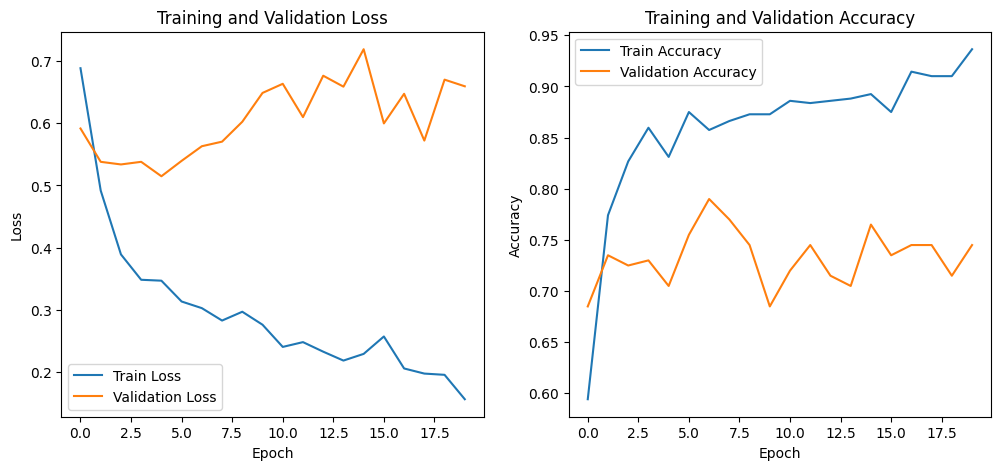

In [31]:
#Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training parameters
num_epochs = 100
patience = 15  # Number of epochs to wait before stopping if no improvement
min_delta = 0.001  # Minimum change to qualify as an improvement

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

best_val_loss = float('inf')  # Initialize to infinity
early_stopping_counter = 0    # Count epochs without improvement

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_accuracy = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Check for improvement in validation loss
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset the counter
        print("Validation loss improved. Saving model...")
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1
        print(f"No improvement for {early_stopping_counter} epoch(s).")

    # Stop training if patience is exceeded
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Confusion Matrix:
[[80 20]
 [24 76]]


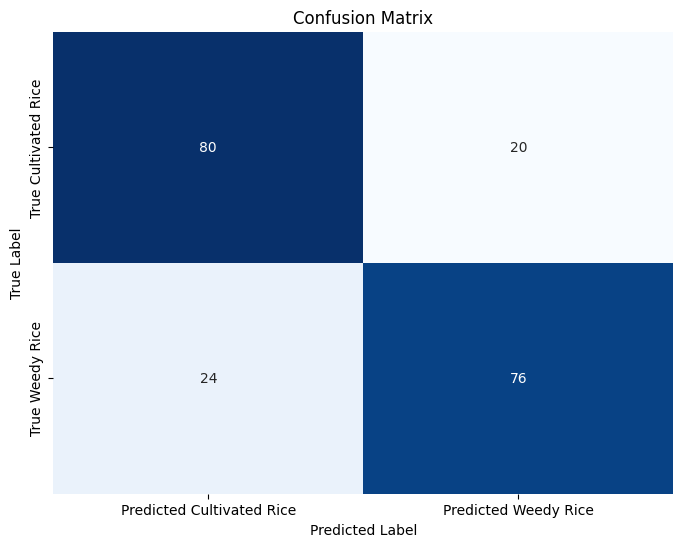


Metrics for each class:
Cultivated Rice: Precision = 0.7692, Recall = 0.8000, F-score = 0.7843
Weedy Rice: Precision = 0.7917, Recall = 0.7600, F-score = 0.7755


In [32]:


def evaluate_model_per_class(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=['Cultivated Rice', 'Weedy Rice'], output_dict=True)

    # Extract metrics for each class
    metrics = {
        "Precision": [report['Cultivated Rice']['precision'], report['Weedy Rice']['precision']],
        "Recall": [report['Cultivated Rice']['recall'], report['Weedy Rice']['recall']],
        "F-score": [report['Cultivated Rice']['f1-score'], report['Weedy Rice']['f1-score']]
    }

    return cm, metrics

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Cultivated Rice', 'Predicted Weedy Rice'],
                yticklabels=['True Cultivated Rice', 'True Weedy Rice'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have trained your model and test_loader is defined
cm, metrics = evaluate_model_per_class(model, test_loader)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)
plot_confusion_matrix(cm)

# Display metrics for each class
print("\nMetrics for each class:")
print(f"Cultivated Rice: Precision = {metrics['Precision'][0]:.4f}, Recall = {metrics['Recall'][0]:.4f}, F-score = {metrics['F-score'][0]:.4f}")
print(f"Weedy Rice: Precision = {metrics['Precision'][1]:.4f}, Recall = {metrics['Recall'][1]:.4f}, F-score = {metrics['F-score'][1]:.4f}")

In [33]:
# Specify the path where you want to save the model
model_path = 'C:\Desktop\CDCS6A\CSP650\Testing and development\Experiment Model\DensenetE2v3.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Desktop\CDCS6A\CSP650\Testing and development\Experiment Model\DensenetE2v3.pth
